# Kalman Filter

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm                                                                                                                          
import statsmodels.formula.api as smf                                                                                                                 
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

%matplotlib inline

/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
df = pd.read_csv('data/response_times.csv', index_col=0, parse_dates=True)
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

In [5]:
f = df.iloc[:360]
    
f.describe()

,value
count,360.000000
mean,14.245911
std,1.636283
min,11.809258
25%,13.153147
50%,13.928394
75%,14.717499
max,21.017907


In [6]:
def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    predictions = []
    residuals = []
    for z in data:
        #prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx    + h * (residual) / dt
        x_est  = x_pred + g * residual
        predictions.append(x_pred)
        residuals.append(residual)
        results.append(x_est)  
    return (np.array(results), np.array(residuals), np.array(predictions))

In [7]:
data1 = g_h_filter(data=f['value'], x0=14.24, dx=1.64, g=0.8, h=0.1, dt=1.)
data2 = g_h_filter(data=f['value'], x0=14.24, dx=1.64, g=0.4, h=0.1, dt=1.)
data3 = g_h_filter(data=f['value'], x0=14.24, dx=1.64, g=0.4, h=0.1, dt=1.)

#data1 = g_h_filter(data=f['value'], x0=11, dx=1.64, g=0.1, h=0.1, dt=1.)
#data2 = g_h_filter(data=f['value'], x0=11, dx=1.64, g=0.1, h=0.4, dt=1.)
#data3 = g_h_filter(data=f['value'], x0=11, dx=1.64, g=0.1, h=0.8, dt=1.)

NameError: name 'data' is not defined

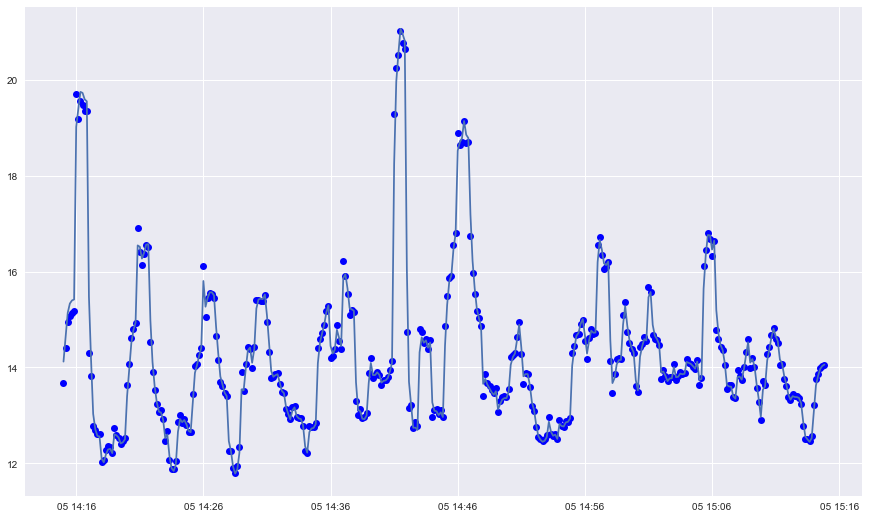

In [8]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ax.plot(f.index,f['value'], 'bo', label="original")
ax.plot(f.index, data1[0], label="results")
ax.plot(f.index, data1[0] - data[2], label="results - predictions")
ax.plot(f.index, data1[1], label="residuals")
ax.plot(f.index, data1[2], label="predictions")

#ax.plot(f.index, data1, label="0.1")
#ax.plot(f.index, data2, label="0.4")
#ax.plot(f.index, data3, label="0.8")

#ax.plot(air.index, air['n_pass_thousands'], 'bo', label="original")
#ax.plot(air.index, data3, label="0.8")


ax.legend()

In [9]:
print(data[359:])

NameError: name 'data' is not defined

In [10]:
f.tail()

,value
date,
2017-08-05 15:14:10,13.761402
2017-08-05 15:14:20,13.854600
2017-08-05 15:14:30,13.986293
2017-08-05 15:14:40,14.024720
2017-08-05 15:14:50,14.047113


In [19]:
def predict(pos, movement):
    return (pos[0] + movement[0], pos[1] + movement[1])

def gaussian_multiply(g1, g2):
    mu1, var1 = g1
    mu2, var2 = g2
    mean = (var1*mu2 + var2*mu1) / (var1 + var2)
    variance = (var1 * var2) / (var1 + var2)
    return (mean, variance)


def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior
process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = (0., 400.)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = (velocity*dt, process_var) 
  
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# run the filter
xs, predictions = [], []
for z in f.value:
    # perform Kalman filter on measurement z
    prior = predict(x, process_model)
    likelihood = (z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior[0])
    xs.append(x[0])
    print("{}\t{}\t{}\t{}\t{}".format(x[0], x[1], z, x, likelihood))
    #kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x[0]))
print('actual final position: {}'.format(f.iloc[-1]))

PREDICT			UPDATE
     x      var		  z	    x      var
13.620490307654169	1.9900744416873448	13.6834353964704	(13.620490307654169, 1.9900744416873448)	(13.683435396470401, 2.0)
14.494168046334853	1.198408751864744	14.409673654116284	(14.494168046334853, 1.198408751864744)	(14.409673654116284, 2.0)
15.203696511527317	1.0472580836195666	14.939440344823874	(15.203696511527317, 1.0472580836195666)	(14.939440344823874, 2.0)
15.634708446276681	1.0116765678499313	15.078854673073193	(15.634708446276681, 1.0116765678499313)	(15.078854673073193, 2.0)
15.886694338167048	1.0029106453754295	15.143022000312946	(15.886694338167048, 1.0029106453754295)	(15.143022000312946, 2.0)
16.035059829433674	1.000727132237836	15.18466292261236	(16.035059829433674, 1.000727132237836)	(15.184662922612359, 2.0)
18.369600938600325	1.0001817500203842	19.703657030171343	(18.369600938600325, 1.0001817500203842)	(19.703657030171343, 2.0)
19.27943112869256	1.000045435440623	19.189269512222616	(19.279431128692561, 1.00004543

In [ ]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P    # posterior variance
    return x, P

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return x, P